# Imports and configs

In [1]:
import tensorflow as tf
import numpy as np
from collections import deque
import gymnasium as gym
import matplotlib.pyplot as plt
import matplotlib.animation
import time
import pickle
import os

# GPU setup immediately after imports
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0], 
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    except RuntimeError as e:
        print(e)

2024-12-05 23:58:28.367942: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-05 23:58:28.509589: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-05 23:58:28.552093: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 23:58:29.410027: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

# Handling code/VM crash

In [2]:
# Function to save training progress
def save_progress(episode, model, replay_buffer, rewards_history, steps_history, 
                  successful_landings, crashes, rolling_reward_avg, times, best_score, 
                  best_weights, start_time, last_print_time):
    save_dict = {
        'episode': episode,
        'replay_buffer': list(replay_buffer),  # Convert deque to list for pickling
        'rewards_history': rewards_history,
        'steps_history': steps_history,
        'successful_landings': successful_landings,
        'crashes': crashes,
        'rolling_reward_avg': rolling_reward_avg,
        'times': times,
        'best_score': best_score,
        'best_weights': best_weights,
        'start_time': start_time,
        'last_print_time': last_print_time
    }
    
    # Save the model weights
    model.save_weights('lunar_lander_checkpoint.h5')
    
    # Save other variables
    with open('training_progress.pkl', 'wb') as f:
        pickle.dump(save_dict, f)
    
    print(f"Progress saved at episode {episode + 1}")

# Check if we're resuming from a checkpoint
resume_training = os.path.exists('training_progress.pkl') and os.path.exists('lunar_lander_checkpoint.h5')

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Initializations

In [3]:
# Create the environment
env = gym.make("LunarLander-v3", render_mode="rgb_array")

print("Num GPUs:", len(tf.config.list_physical_devices('GPU')))
print("GPU Available: ", tf.test.is_built_with_cuda())
print("Devices:", tf.config.list_physical_devices())

# ------------------------ 1. Create a simple DQN epsilon policy network with 4 output neurons (one per possible action).
# [Hint: DQN Agents use Epsilon greedy policy]        [15 points] 
# ------------------------ 2. Discuss the rationale of the activation functions & the loss function used in the network. [10 points]
input_shape = [8]  # LunarLander has 8 observations
n_outputs = 4      # LunarLander has 4 possible actions

# Adjusted Neural Network with increased neurons
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu", input_shape=input_shape),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(n_outputs)
])

# ------------------------ 3. Define the hyperparameters:
# [50 points]
# --------- (i) the number of iterations, 
batch_size = 128  # Increased batch size
# --------- (ii) the number of episodes
n_episodes = 1000
# --------- (iii) the maximum number of steps, and  
n_steps = 1000
training_start = 50
training_interval = 4
# --------- (iv) the discount factor at each step
gamma = 0.99

# Adjusted optimizer and learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer)

# Initialize or load training variables
if resume_training:
    print("Loading saved progress...")
    with open('training_progress.pkl', 'rb') as f:
        saved_progress = pickle.load(f)
    
    start_episode = saved_progress['episode'] + 1
    replay_buffer = deque(saved_progress['replay_buffer'], maxlen=100000)
    rewards_history = saved_progress['rewards_history']
    steps_history = saved_progress['steps_history']
    successful_landings = saved_progress['successful_landings']
    crashes = saved_progress['crashes']
    rolling_reward_avg = saved_progress['rolling_reward_avg']
    times = saved_progress['times']
    best_score = saved_progress['best_score']
    best_weights = saved_progress['best_weights']
    start_time = saved_progress['start_time']
    last_print_time = saved_progress['last_print_time']
    
    model.load_weights('lunar_lander_checkpoint.h5')
    print(f"Resuming training from episode {start_episode}")
else:
    print("Starting new training...")
    start_episode = 0
    replay_buffer = deque(maxlen=100000)
    rewards_history = []
    steps_history = []
    successful_landings = []
    crashes = []
    rolling_reward_avg = []
    times = []
    best_score = -float('inf')
    best_weights = None
    start_time = time.time()
    last_print_time = start_time

def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones, truncateds = zip(*batch)
    return (np.array(states), np.array(actions), np.array(rewards), 
            np.array(next_states), np.array(dones), np.array(truncateds))

def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[0]
        return np.argmax(Q_values)

def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

def training_step(batch_size, gamma=0.99):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    
    states = tf.cast(states, tf.float32)
    next_states = tf.cast(next_states, tf.float32)
    rewards = tf.cast(rewards, tf.float32)
    
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    runs = 1.0 - (dones | truncateds)
    target_Q_values = rewards + runs * gamma * max_next_Q_values
    
    mask = tf.one_hot(actions, n_outputs, dtype=tf.float32)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1)
        loss = tf.reduce_mean(tf.square(target_Q_values - Q_values))
    
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return loss

# Adjusted epsilon decay function
def get_epsilon(episode, n_episodes):
    epsilon_start = 1.0
    epsilon_end = 0.01
    decay_episodes = 700  # Decay over 700 episodes
    epsilon = max(epsilon_end, epsilon_start - (epsilon_start - epsilon_end) * (episode / decay_episodes))
    return epsilon

Num GPUs: 1
GPU Available:  True
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-12-05 23:58:31.155174: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-05 23:58:31.914303: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4096 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


Loading saved progress...
Resuming training from episode 1000


# Training

In [4]:
# ------------------------ 4. Train the agent on the LunarLander-v2 or v3 environment for a sufficient number of episodes
# to achieve a satisfactory level of performance. [10 points]# Training loop
print("\nStarting training...\n")
print("Episode  Steps  Outcome  Avg-Reward(20)  Time(5ep)  Epsilon")
print("-" * 65)

# If resuming training, reconstruct and print the progress table
if resume_training and len(rewards_history) > 0:
    print("\nReconstructing progress table from saved data...\n")
    previous_episodes = len(rewards_history)
    times_len = len(times)

    # Initialize last_print_time for accurate time calculations
    if times_len > 0:
        last_print_time = times[0] - (times[1] - times[0]) if times_len > 1 else start_time
    else:
        last_print_time = start_time

    # Calculate the number of complete 5-episode intervals
    num_complete_intervals = previous_episodes // 5

    # Adjust the loop to prevent IndexError
    for idx in range(min(times_len, num_complete_intervals)):
        # Each time corresponds to episode_num = (idx + 1) * 5
        episode_num = (idx + 1) * 5
        episode_idx = episode_num - 1  # zero-based index

        # Check if episode_idx is within the bounds of the data
        if episode_idx >= previous_episodes:
            break  # No more data to process

        # Retrieve data for the episode
        episode_steps = steps_history[episode_idx]
        episode_reward = rewards_history[episode_idx]
        avg_reward = rolling_reward_avg[episode_idx] if episode_idx < len(rolling_reward_avg) else np.mean(rewards_history[max(0, episode_idx-19):episode_idx+1])
        epsilon = get_epsilon(episode_idx, n_episodes)
        current_time = times[idx]
        time_for_last_5 = current_time - last_print_time
        last_print_time = current_time
        final_reward = rewards_history[episode_idx]

        # Determine outcome based on success condition
        if episode_reward >= 200:
            outcome = "SUCCESS"
        else:
            outcome = "CRASH"

        log_entry = f"{episode_num:7d}  {episode_steps:5d}  {outcome:7s}  {avg_reward:13.2f}  {time_for_last_5:9.2f}  {epsilon:.3f}"
        print(log_entry)

try:
    for episode in range(start_episode, n_episodes):
        obs, info = env.reset()
        epsilon = get_epsilon(episode, n_episodes)
        episode_reward = 0
        episode_steps = 0
        final_reward = 0
        
        for step in range(n_steps):
            obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
            episode_reward += reward
            episode_steps += 1
            
            if episode > training_start and step % training_interval == 0:
                if len(replay_buffer) >= batch_size:
                    training_step(batch_size, gamma)
            
            if done or truncated:
                final_reward = reward
                break
        
        # Update tracking
        rewards_history.append(episode_reward)
        steps_history.append(episode_steps)
        
        if episode_reward > best_score:
            best_score = episode_reward
            best_weights = model.get_weights()
        
        # Track outcomes
        if episode_reward >= 200:
            successful_landings.append(episode)
            outcome = "SUCCESS"
        else:
            crashes.append(episode)
            outcome = "CRASH"
            
        recent_rewards = rewards_history[-20:] if len(rewards_history) >= 20 else rewards_history
        avg_reward = np.mean(recent_rewards)
        rolling_reward_avg.append(avg_reward)
        
        # Print progress and save checkpoint
        if (episode + 1) % 5 == 0:
            current_time = time.time()
            time_for_last_5 = current_time - last_print_time
            times.append(current_time)
            print(f"{episode+1:7d}  {episode_steps:5d}  {outcome:7s}  {avg_reward:13.2f}  {time_for_last_5:9.2f}  {epsilon:.3f}")
            last_print_time = current_time
            
        if (episode + 1) % 25 == 0:  # Save every 25 episodes
            save_progress(episode, model, replay_buffer, rewards_history, steps_history,
                          successful_landings, crashes, rolling_reward_avg, times,
                          best_score, best_weights, start_time, last_print_time)

except KeyboardInterrupt:
    print("\nTraining interrupted. Saving progress...")
    save_progress(episode, model, replay_buffer, rewards_history, steps_history,
                  successful_landings, crashes, rolling_reward_avg, times,
                  best_score, best_weights, start_time, last_print_time)
    print("Progress saved. You can resume training by running this script again.")


Starting training...

Episode  Steps  Outcome  Avg-Reward(20)  Time(5ep)  Epsilon
-----------------------------------------------------------------

Reconstructing progress table from saved data...

      5    111  CRASH          -282.36       0.60  0.994
     10    157  CRASH          -247.50       0.60  0.987
     15     82  CRASH          -243.03       0.42  0.980
     20    103  CRASH          -239.75       0.61  0.973
     25     88  CRASH          -235.71       1.16  0.966
     30    135  CRASH          -229.04       1.52  0.959
     35     67  CRASH          -209.63       1.12  0.952
     40    114  CRASH          -236.28       2.00  0.945
     45     60  CRASH          -199.17       1.01  0.938
     50    120  CRASH          -178.77       1.36  0.931
     55     75  CRASH          -178.48      10.27  0.924
     60    101  CRASH          -119.55       9.25  0.917
     65     78  CRASH          -131.87      11.44  0.909
     70    129  CRASH          -148.33      12.63  0.902
  

# Analysis


Training Summary:
Total training time: 6:25:21
Episodes hitting max steps: 109/1000
Successful landings: 389/1000 (38.9%)
Crashes: 611/1000 (61.1%)
Best score achieved: 322.44


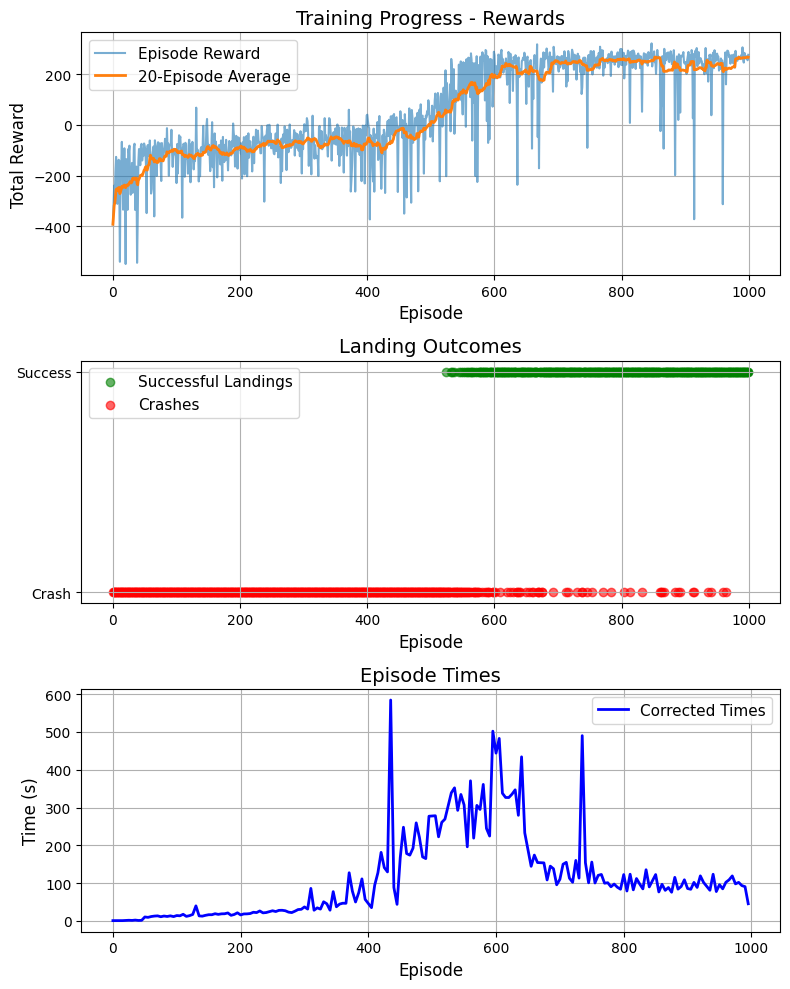

In [7]:
# ------------------------ 5. Analyze the agent's learning progress by plotting relevant performance metrics
# (e.g., cumulative rewards, episode length) over time. [10 points]
# Restore best weights
model.set_weights(best_weights)

# Final Analysis
def calculate_times_with_interpolation(timestamps):
    # Calculate the time differences
    times = [timestamps[1] - timestamps[0]]  # Assume the first difference equals the second
    times += [timestamps[i] - timestamps[i - 1] for i in range(1, len(timestamps))]

    # Identify indices with times > 1000
    for i in range(len(times)):
        if times[i] > 1000:
            # Interpolate using previous and next values
            prev_time = times[i - 1] if i > 0 else 0
            next_time = times[i + 1] if i + 1 < len(times) else 0
            times[i] = (prev_time + next_time) / 2

    return times
    
# Calculate corrected times
corrected_times = calculate_times_with_interpolation(times)
import datetime
total_time = np.sum(corrected_times)
total_time = str(datetime.timedelta(seconds=int(total_time)))
print("\nTraining Summary:")
print(f"Total training time: {total_time}")
print(f"Episodes hitting max steps: {sum(1 for s in steps_history if s >= 999)}/{n_episodes}")
print(f"Successful landings: {len(successful_landings)}/{n_episodes} ({len(successful_landings)/n_episodes*100:.1f}%)")
print(f"Crashes: {len(crashes)}/{n_episodes} ({len(crashes)/n_episodes*100:.1f}%)")
print(f"Best score achieved: {best_score:.2f}")

# Plot training results
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))

# Font size configuration
font_title = 14
font_label = 12
font_tick = 10
font_legend = 11

ax1.plot(rewards_history, alpha=0.6, label='Episode Reward')
ax1.plot(rolling_reward_avg, label='20-Episode Average', linewidth=2)
ax1.set_title('Training Progress - Rewards', fontsize=font_title)
ax1.set_xlabel('Episode', fontsize=font_label)
ax1.set_ylabel('Total Reward', fontsize=font_label)
ax1.tick_params(axis='both', labelsize=font_tick)
ax1.grid(True)
ax1.legend(fontsize=font_legend)

episodes = range(1, len(rewards_history) + 1)
ax2.scatter(successful_landings, [1]*len(successful_landings), color='green', label='Successful Landings', alpha=0.6)
ax2.scatter(crashes, [0]*len(crashes), color='red', label='Crashes', alpha=0.6)
ax2.set_title('Landing Outcomes', fontsize=font_title)
ax2.set_xlabel('Episode', fontsize=font_label)
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['Crash', 'Success'], fontsize=font_tick)
ax2.tick_params(axis='both', labelsize=font_tick)
ax2.grid(True)
ax2.legend(fontsize=font_legend)

# Correct x-axis to match every 5 episodes, ending at 1000
x_axis_corrected = [i * 5 for i in range(len(corrected_times))]

ax3.plot(x_axis_corrected, corrected_times, color='blue', linewidth=2, label='Corrected Times')
ax3.set_title('Episode Times', fontsize=font_title)
ax3.set_xlabel('Episode', fontsize=font_label)  # Updated label to "Episode"
ax3.set_ylabel('Time (s)', fontsize=font_label)
ax3.tick_params(axis='both', labelsize=font_tick)
ax3.grid(True)
ax3.legend(fontsize=font_legend)

plt.tight_layout()
plt.show()

# Animation

2024-12-05 23:58:34.664943: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Landing status: Success!
Total reward: 287.06
Total steps: 216


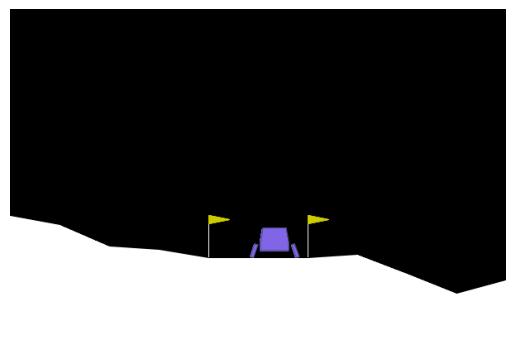

In [6]:
def plot_animation(frames, repeat=False, interval=40):
    plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        plt.gcf(), lambda i: patch.set_data(frames[i]),
        frames=len(frames), repeat=repeat, interval=interval)
    from IPython.display import HTML
    return HTML(anim.to_jshtml())  # This line is key for Jupyter display

def show_video(env, model, max_steps=1000):
    frames = []
    obs, _ = env.reset()
    total_reward = 0
    total_steps = 0
    
    for step in range(max_steps):
        frames.append(env.render())
        action = epsilon_greedy_policy(obs, epsilon=0)
        obs, reward, done, truncated, _ = env.step(action)
        total_reward += reward
        total_steps += 1
        if done or truncated:
            print("Landing status:", "Success!" if total_reward >= 200 else "Crash!")
            print(f"Total reward: {total_reward:.2f}")
            print(f"Total steps: {total_steps}")
            break
    
    env.close()
    return plot_animation(frames)
    
# Show the final performance
show_video(env, model)